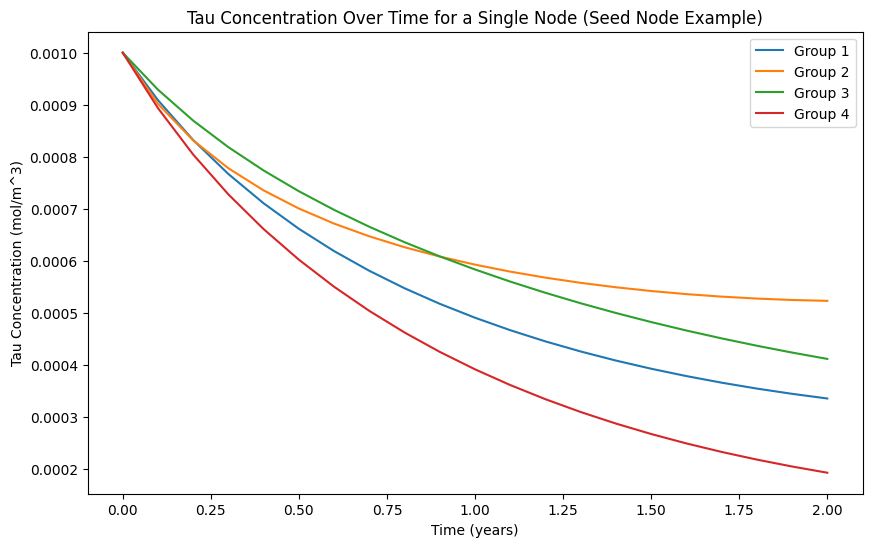

<ipython-input-7-8f955ff62014>:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


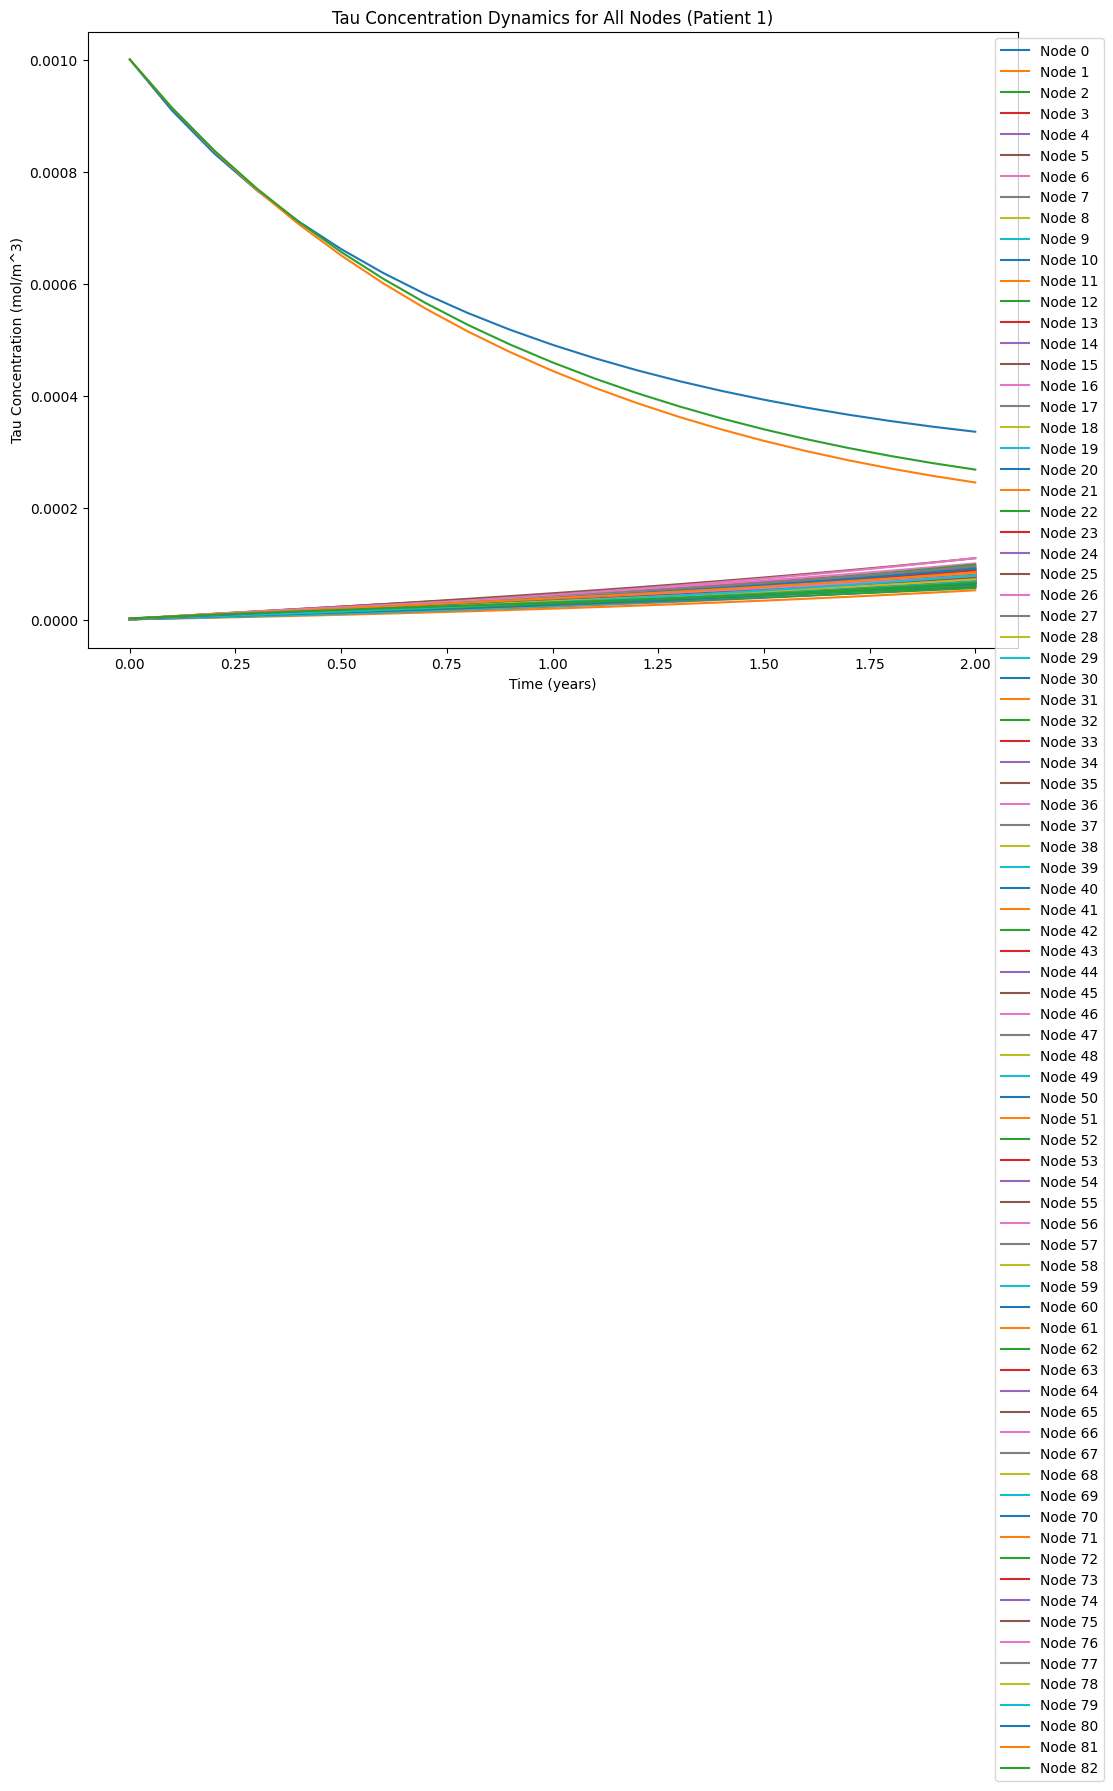

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

# Define constants
NUM_SUBJECTS = 76
NUM_GROUPS = 4
NUM_NODES = 83
GROUP_SIZE = NUM_SUBJECTS // NUM_GROUPS
TIME_STEP = 0.1  # Smaller time step
TIME_POINTS = int(2 / TIME_STEP) + 1  # Simulating from 0 to 2 years

# Reaction terms with saturation
def reaction_term_1(c, max_tau=1e-3):
    return c * (1 - c / max_tau)

def reaction_term_2(c, max_tau=1e-3):
    return c * (1 - (c / max_tau)**2)

def reaction_term_3(c, max_tau=1e-3):
    return c * (1 - (c / max_tau)**3)

def reaction_term_4(c, max_tau=1e-3):
    return c * (1 - c / max_tau) * np.exp(c / max_tau - 1)

reaction_terms = [reaction_term_1, reaction_term_2, reaction_term_3, reaction_term_4]

# Sample from given distributions for parameters
def sample_parameters(num_subjects, num_nodes):
    kappa = np.random.normal(1, 0.52, num_subjects)
    alpha_i = np.random.normal(0.6, 0.12, num_subjects)
    alpha_ij = np.array([np.random.normal(ai, 0.22, num_nodes) for ai in alpha_i])
    return kappa, alpha_i, alpha_ij

# Generate initial tau concentrations using log-normal distribution
real_data_mean = 1e-6  # Mean tau concentration in mol/m^3
real_data_std = 0.5e-6  # Standard deviation
def generate_initial_conditions_log_normal(num_subjects, num_nodes):
    return np.random.lognormal(mean=np.log(real_data_mean), sigma=np.log(1 + real_data_std / real_data_mean), size=(num_subjects, num_nodes))

# Set higher tau concentrations in specific "seed" nodes
def set_high_tau_nodes(initial_conditions, high_tau_value=1e-3, nodes=[0, 1, 2]):
    for subj in range(initial_conditions.shape[0]):
        initial_conditions[subj, nodes] = high_tau_value
    return initial_conditions

# Generate a realistic connectivity matrix (Laplacian)
def generate_connectivity_matrix(num_nodes):
    A = np.random.rand(num_nodes, num_nodes)
    A = (A + A.T) / 2  # Make symmetric
    np.fill_diagonal(A, 0)  # No self-loops
    D = np.diag(A.sum(axis=1))  # Degree matrix
    L = D - A  # Graph Laplacian
    # Normalize Laplacian
    max_eigenvalue = np.max(np.linalg.eigvalsh(L))
    return L / max_eigenvalue

# Simulate tau concentration dynamics over time
def simulate_tau_dynamics(initial_conditions, kappa, alpha_ij, reaction_terms, L, time_step, time_points):
    num_subjects, num_nodes = initial_conditions.shape
    c = np.zeros((num_subjects, num_nodes, time_points))
    c[:, :, 0] = initial_conditions

    for t in range(1, time_points):
        for subj in range(num_subjects):
            group = subj // GROUP_SIZE
            f = reaction_terms[group]
            for i in range(num_nodes):
                diffusion = -kappa[subj] * np.dot(L[i, :], c[subj, :, t-1])
                reaction = alpha_ij[subj, i] * f(c[subj, i, t-1])
                c[subj, i, t] = max(0, c[subj, i, t-1] + time_step * (diffusion + reaction))  # Enforce non-negativity
    return c

# Main workflow
L = generate_connectivity_matrix(NUM_NODES)  # Generate realistic brain connectivity
kappa, alpha_i, alpha_ij = sample_parameters(NUM_SUBJECTS, NUM_NODES)  # Sample parameters
initial_conditions = generate_initial_conditions_log_normal(NUM_SUBJECTS, NUM_NODES)  # Generate initial concentrations
initial_conditions = set_high_tau_nodes(initial_conditions)  # Set seed nodes with high tau concentrations
tau_concentration = simulate_tau_dynamics(initial_conditions, kappa, alpha_ij, reaction_terms, L, TIME_STEP, TIME_POINTS)

# Plot example dynamics for a single node
plt.figure(figsize=(10, 6))
for group in range(NUM_GROUPS):
    plt.plot(np.arange(0, 2 + TIME_STEP, TIME_STEP), tau_concentration[group * GROUP_SIZE, 0, :], label=f"Group {group + 1}")
plt.xlabel("Time (years)")
plt.ylabel("Tau Concentration (mol/m^3)")
plt.title("Tau Concentration Over Time for a Single Node (Seed Node Example)")
plt.legend()
plt.show()

# Optionally, plot tau dynamics for all nodes of a single patient
single_patient_idx = 0  # You can select any patient here
plt.figure(figsize=(12, 8))
for i in range(NUM_NODES):
    plt.plot(np.arange(0, 2 + TIME_STEP, TIME_STEP), tau_concentration[single_patient_idx, i, :], label=f"Node {i}")
plt.xlabel("Time (years)")
plt.ylabel("Tau Concentration (mol/m^3)")
plt.title(f"Tau Concentration Dynamics for All Nodes (Patient {single_patient_idx + 1})")
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()


In [ ]:
# Reshape the data for export
reshaped_data = []
for subj in range(num_subjects):
    for node in range(num_nodes):
        for t in range(time_points):
            reshaped_data.append([subj, node, t, c[subj, node, t]])

# Convert to a pandas DataFrame
df = pd.DataFrame(reshaped_data, columns=['Subject', 'Node', 'Time (years)', 'Tau Concentration (mol/m^3)'])

# Define the file path for the CSV file
csv_file_path = 'tau_concentration_data.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)